# Repeat Copy Task
### Differentiable Neural Computer (DNC) using a RNN Controller

<a href="http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html"><img src="../static/dnc_schema.png" alt="DNC schema" style="width: 700px;"/></a>

**Sam Greydanus $\cdot$ February 2017 $\cdot$ MIT License.**

Represents the state of the art in differentiable memory. Inspired by this [Nature paper](http://www.nature.com/nature/journal/v538/n7626/full/nature20101.html). Some ideas taken from [this Gihub repo](https://github.com/Mostafa-Samir/DNC-tensorflow)

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.insert(0, '../dnc')

from dnc import DNC
from utils import *
from rnn_controller import RNNController

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

### Hyperparameters

In [2]:
alphabet = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
stroke_steps = 175
tf.app.flags.DEFINE_integer("xlen", len(alphabet) + 4, "Input dimension")
tf.app.flags.DEFINE_integer("ylen", 3, "output dimension")
tf.app.flags.DEFINE_integer("stroke_steps", stroke_steps, "Number of time steps for stroke data")
tf.app.flags.DEFINE_integer("ascii_steps", stroke_steps/25, "Sequence length")
tf.app.flags.DEFINE_integer("data_scale", 50, "How to scale stroke data")
tf.app.flags.DEFINE_integer("batch_size", 2, "Size of batch in minibatch gradient descent")

tf.app.flags.DEFINE_integer("R", 1, "Number of DNC read heads")
tf.app.flags.DEFINE_integer("W", 16, "Word length for DNC memory")
tf.app.flags.DEFINE_integer("N", 10, "Number of words the DNC memory can store")

tf.app.flags.DEFINE_integer("train", True, "Train or sample???")
tf.app.flags.DEFINE_integer("print_every", 100, "Print training info after this number of train steps")
tf.app.flags.DEFINE_integer("iterations", 5000000, "Number of training iterations")
tf.app.flags.DEFINE_float("lr", 1e-4, "Learning rate (alpha) for the model")
tf.app.flags.DEFINE_float("momentum", .9, "RMSProp momentum")
tf.app.flags.DEFINE_integer("save_every", 1000, "Save model after this number of train steps")
tf.app.flags.DEFINE_string("save_path", "models/model.ckpt", "Where to save checkpoints")
tf.app.flags.DEFINE_string("data_dir", "data/", "Where to save checkpoints")
tf.app.flags.DEFINE_string("log_dir", "logs/", "Where to find data")
tf.app.flags.DEFINE_string("alphabet", alphabet, "Viable characters")
FLAGS = tf.app.flags.FLAGS

### Data functions

In [3]:
def next_batch(FLAGS, dl):
    X_batch = []
    y_batch = []
    text = []
    _X_batch, _y_batch, _text, _one_hots = dl.next_batch()
    for i in range(FLAGS.batch_size):
        ascii_part = np.concatenate((_one_hots[i], np.zeros((FLAGS.ascii_steps, 3))), axis=1)
        X_stroke_part = np.concatenate((np.zeros((FLAGS.stroke_steps, len(FLAGS.alphabet)+1)), _X_batch[i]), axis=1)
        
        X = np.concatenate((ascii_part, X_stroke_part), axis=0)
        y = np.concatenate((np.zeros((FLAGS.ascii_steps, 3)), _y_batch[i]), axis=0)
        X_batch.append(X) ; y_batch.append(y) ; text.append(_text)
    return [X_batch, y_batch, text]

In [4]:
def line_plot(strokes, title, figsize = (20,2), save_path='.'):
    plt.figure(figsize=figsize)
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0) #draw a stroke
    plt.title(title,  fontsize=20)
    plt.gca().invert_yaxis()
    plt.plot()

	loaded dataset:
		11895 individual data points
		5947 batches


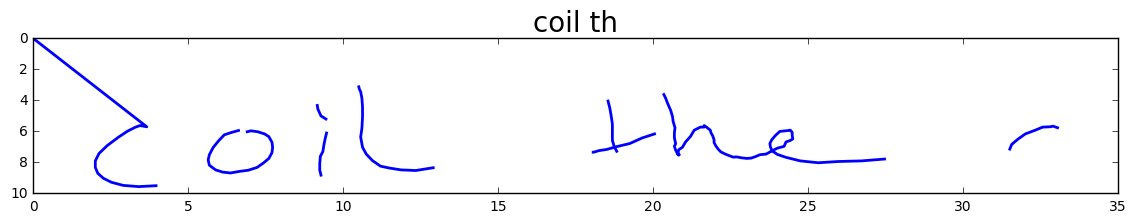

In [5]:
logger = Logger(FLAGS)
dl = Dataloader(FLAGS, logger, limit = 500)
batch = next_batch(FLAGS, dl)

X = batch[0][0]
strokes = np.cumsum(X[:,-3:-1],axis=0)
strokes = np.concatenate((strokes, X[:,-1:]),axis=1)
line_plot(strokes, title=batch[2][0][0], figsize = (FLAGS.ascii_steps*2,2), save_path='.')

### Helper functions

In [6]:
def binary_cross_entropy(y_hat, y):
    return tf.reduce_mean(-y*tf.log(y_hat) - (1-y)*tf.log(1-y_hat))

def llprint(message):
    sys.stdout.write(message)
    sys.stdout.flush()

### Build graph, initialize everything

In [7]:
sess = tf.InteractiveSession()

llprint("building graph...\n")
optimizer = tf.train.RMSPropOptimizer(FLAGS.lr, momentum=FLAGS.momentum)
dnc = DNC(RNNController, FLAGS, input_steps=FLAGS.ascii_steps)

llprint("defining loss...\n")
y_hat, outputs = dnc.get_outputs()
# TODO: fix this loss: l2 on [:,:,:2] and then do binary cross entropy on <EOS> tags
loss = tf.nn.l2_loss(dnc.y - y_hat)*100./(FLAGS.batch_size*(FLAGS.ascii_steps+FLAGS.stroke_steps))

llprint("computing gradients...\n")
gradients = optimizer.compute_gradients(loss)
for i, (grad, var) in enumerate(gradients):
    if grad is not None:
        gradients[i] = (tf.clip_by_value(grad, -10, 10), var)
                    
grad_op = optimizer.apply_gradients(gradients)

llprint("init variables... \n")
sess.run(tf.global_variables_initializer())
llprint("ready to train...")

building graph...
defining loss...
computing gradients...
init variables... 
ready to train...

In [8]:
total_parameters = 0 ; print "model overview..."
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "total of {} parameters".format(total_parameters)

model overview...
	variable "dnc_scope/basic_lstm_cell/weights:0" has 133200 parameters
	variable "dnc_scope/basic_lstm_cell/biases:0" has 600 parameters
	variable "W_z:0" has 10800 parameters
	variable "W_v:0" has 450 parameters
	variable "W_r:0" has 48 parameters
total of 145098 parameters


In [9]:
# try load saved model
global_step = 0
saver = tf.train.Saver(tf.global_variables())
load_was_success = True # yes, I'm being optimistic
try:
    save_dir = '/'.join(FLAGS.save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print "no saved model to load."
    load_was_success = False
else:
    print "loaded model: {}".format(load_path)
    saver = tf.train.Saver(tf.global_variables())
    global_step = int(load_path.split('-')[-1]) + 1

loaded model: models/model.ckpt-21000


### Train loop

In [10]:
# loss_history = []
# for i in xrange(global_step, FLAGS.iterations + 1):
#     llprint("\rIteration {}/{}".format(i, FLAGS.iterations))

#     X, y, text = next_batch(FLAGS, dl)
#     tsteps = FLAGS.ascii_steps + FLAGS.stroke_steps

#     fetch = [loss, grad_op]
#     feed = {dnc.X: X, dnc.y: y, dnc.tsteps: tsteps}

#     step_loss, _ = sess.run(fetch, feed_dict=feed)
#     loss_history.append(step_loss)
#     global_step = i

#     if i % 100 == 0:
#         llprint("\n\tloss: {:03.4f}\n".format(np.mean(loss_history)))
#         loss_history = []
#     if i % FLAGS.save_every == 0 and i is not 0:
#         llprint("\n\tSAVING MODEL\n")
#         saver.save(sess, FLAGS.save_path, global_step=global_step)

In [11]:
# test_string = 'You know nothing Jon Snow'
# oh = to_one_hot(test_string, FLAGS.ascii_steps, FLAGS.alphabet)
# primer_ascii = np.concatenate((oh, np.zeros((FLAGS.ascii_steps, 3))), axis=1)

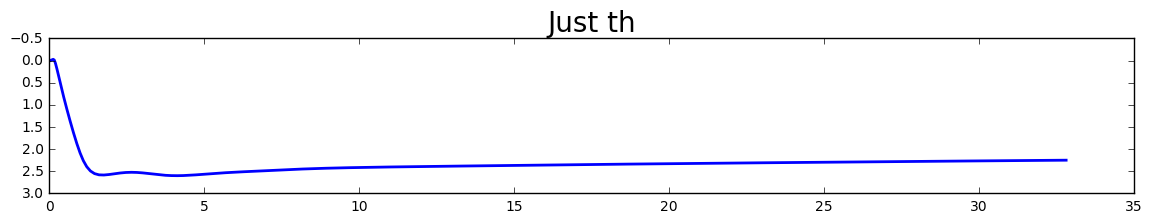

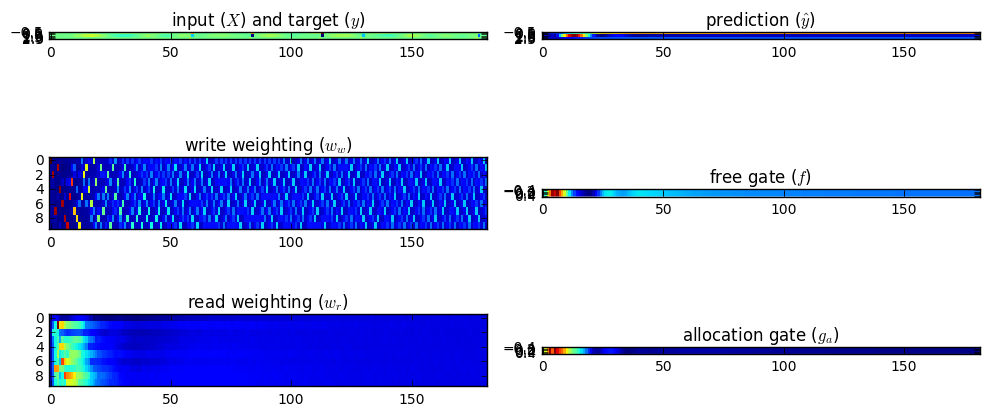

In [22]:
X, y, text = next_batch(FLAGS, dl)
tsteps = FLAGS.ascii_steps + FLAGS.stroke_steps

feed = {dnc.X: X, dnc.tsteps: tsteps}
fetch = [outputs['y_hat'], outputs['w_w'], outputs['w_r'], outputs['f'], outputs['g_a']]
[_y_hat, _w_w, _w_r, _f, _g_a] = sess.run(fetch, feed)
_y = y[0] ; _X = X[0]

strokes = np.cumsum(_y_hat[0,:,-3:-1],axis=0)
eos_thresh = 0.15
eos_flags = (_y_hat[0,:,-1:] > eos_thresh).astype(np.int32)
strokes = np.concatenate((strokes, eos_flags),axis=1)
line_plot(strokes, title=text[0][0], figsize = (FLAGS.ascii_steps*2,2), save_path='.')

fig, ((ax1,ax2),(ax3,ax5),(ax4,ax6),) = plt.subplots(nrows=3, ncols=2)
plt.rcParams['savefig.facecolor'] = "0.8"
fs = 12 # font size
fig.set_figwidth(10)
fig.set_figheight(5)

ax1.imshow(_y.T, interpolation='none') ; ax1.set_title('input ($X$) and target ($y$)')
ax2.imshow(_y_hat[0,:,:].T, interpolation='none') ; ax2.set_title('prediction ($\hat y$)')

ax3.imshow(_w_w[0,:,:].T, interpolation='none') ; ax3.set_title('write weighting ($w_w$)') ; ax3.set_aspect(3)
ax4.imshow(_w_r[0,:,:,0].T, interpolation='none') ; ax4.set_title('read weighting ($w_r$)') ; ax4.set_aspect(3)

ax5.imshow(_f[0,:,:].T, interpolation='none') ; ax5.set_title('free gate ($f$)') ; ax5.set_aspect(3)
ax6.imshow(_g_a[0,:,:].T, interpolation='none') ; ax6.set_title('allocation gate ($g_a$)') ; ax6.set_aspect(3)

plt.tight_layout()